In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
aorc = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/v0/baselines/aorc/aorc.zarr", decode_timedelta=True)
gfs = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/v0/baselines/gfs-forecasts-vs-aorc/gfs.forecasts.zarr", decode_timedelta=True)
mask = xr.open_dataset("/pscratch/sd/t/timothys/nested-eagle/v0/baselines/aorc/mask.nc")["aorc_mask"]

hrrr = xr.concat(
    [
        xr.open_zarr(f"/pscratch/sd/t/timothys/nested-eagle/v0/baselines/hrrr-forecasts-vs-aorc/hrrr.forecasts.{fhr:02d}h.zarr", decode_timedelta=True)
        for fhr in [6, 12, 24, 48]
    ],
    dim="fhr",
)
nested = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/v0/10percent/csmswt/logoffline-trim10-ll10-win4320/inference-precip/nested-eagle.conus15km.precip.zarr/", decode_timedelta=True)

## Trim the mask for the nested model

When creating the nested model domain, I cut off 10 coarsened grid cells (so 50 original grid cells = 150km) on the left and lower boundaries, and 11 coarsened grid cells (55 original = 165km) on the right and upper boundaries.
This is to eliminate any "untrustworthy" data points that exist in regional domains between the boundary conditions and the domain.
(it's likely overkill, and there's no telling what the right number is, but this looked fine ...)

This means we have to trim the mask and AORC data before comparing to the nested region.
Note that most of what is being trimmed (if not all) are just NaNs in the ocean, so this should have basically no impact on the result.

Below is an example of how it's done with the mask, should be the same for the aorc dataset during computation.

In [31]:
trimmed_mask = mask.isel(x=slice(10,-11), y=slice(10,-11))
trimmed_mask["x"] = np.arange(len(nested.x))
trimmed_mask["y"] = np.arange(len(nested.y))

## Correct valid time

For some reason this gets messed up in ufs2arco, but we can just recompute it.

In [3]:
def calc_valid_time(xds):
    lead_time = xr.DataArray(
        [pd.Timedelta(hours=fhr) for fhr in xds.fhr.values],
        coords=xds.fhr.coords,
    )
    return xds["t0"] + lead_time

In [4]:
gfs["valid_time"] = calc_valid_time(gfs)
hrrr["valid_time"] = calc_valid_time(hrrr)
nested["valid_time"] = calc_valid_time(nested)

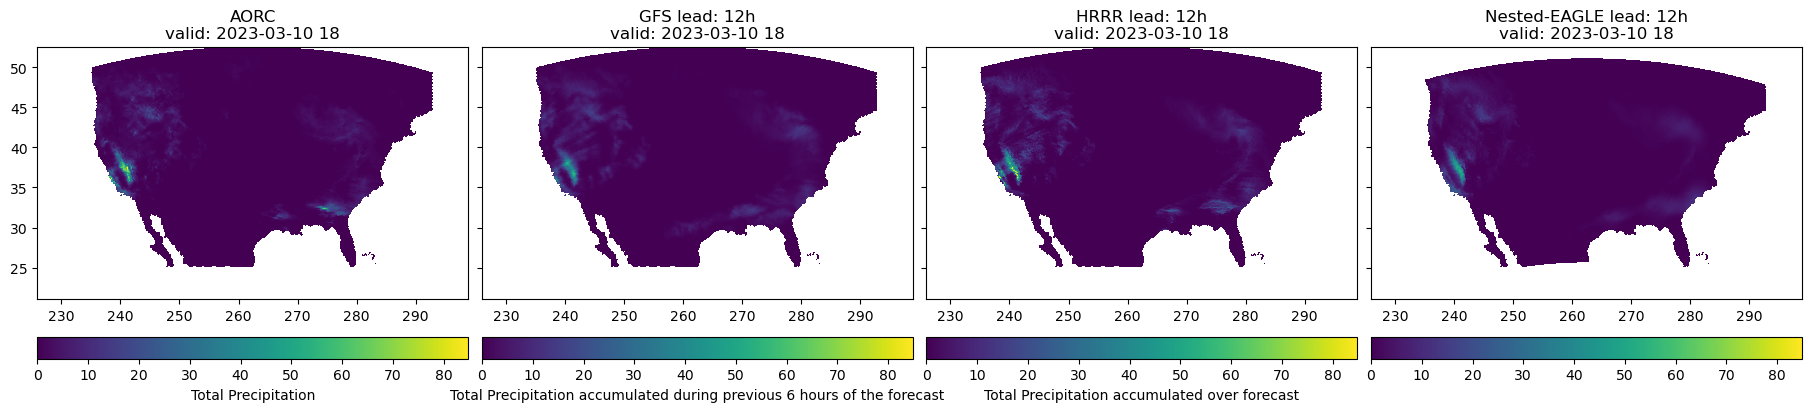

In [38]:
t0 = "2023-03-10T06"
fhr = 12
vtime = pd.Timestamp(t0) + pd.Timedelta(hours=fhr)
stime = str(vtime)[:13]

fig, axs = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True, sharey=True, sharex=True)

kw = {
    "vmax": aorc.accum_tp.sel(time=vtime).max().values,
    "vmin": 0,
}

for xds, label, ax in zip([aorc, gfs, hrrr, nested], ["AORC", "GFS", "HRRR", "Nested-EAGLE"], axs):

    if "Nested" not in label:
        plotme = xds.accum_tp.where(mask)
    else:
        plotme = xds.accum_tp.where(trimmed_mask)
    
    title = f"{label}"
    if "fhr" in plotme.dims:
        plotme = plotme.sel(t0=t0, fhr=fhr)
        title += f" lead: {fhr}h\nvalid: {stime}"
    else:
        plotme = plotme.sel(time=vtime)
        title += f"\nvalid: {stime}"
    p = ax.pcolormesh(
        xds.longitude,
        xds.latitude,
        plotme,
        **kw,
    )
    plt.colorbar(p, ax=ax, label=xds.accum_tp.attrs.get("long_name", ""), orientation="horizontal")
    
    ax.set(title=title, ylabel="", xlabel="")